In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year # Don't really neeed this

Makes a FaIR object and the methane life time method. Version 2 uses the version from Nick Leaches paper.

By default this is the one that is used but you can specify it if you put 'leach2021' in here.

By using 'thornhill2021' we are using the version with interactive methane lifetime. 

In [2]:
f = FAIR(ch4_method='thornhill2021')

In [3]:
help(f.define_time)

Help on method define_time in module fair.fair:

define_time(start, end, step) method of fair.fair.FAIR instance
    Define timebounds vector to run FaIR.
    
    Parameters
    ----------
    start : float
        first timebound of the model (year)
    end : float
        last timebound of the model (year)
    step : float
        timestep (year)



In [4]:
f.define_time(1750, 2100, 1)

In [5]:
# Define SSP scenarios
scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
f.define_scenarios(scenarios)

print (f.scenarios)

['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']


In [6]:
df = pd.read_csv("4xCO2_cummins_ebm3.csv")
models = df['model'].unique()
configs = []

for imodel, model in enumerate(models):
    for run in df.loc[df['model']==model, 'run']:
        configs.append(f"{model}_{run}")
f.define_configs(configs)

FileNotFoundError: [Errno 2] No such file or directory: '4xCO2_cummins_ebm3.csv'

In [ ]:
f.configs

Read_properties is imported at the beginning, takes list of default species and properties including GHGs, shortlived forcing and anything you want to calculate and anything you want to calculate a forcing for (so any of the 40 species and things like aerosol cloud forcing).

In [ ]:
species, properties = read_properties()
#species = list(properties.keys())

In [ ]:
f.define_species(species, properties)

In [ ]:
species

You can modify the input_mode to be concentrations if you don't have all the gases as emissions. 
You have to have both fossil emissions and AFOLU emissions to run in emissions mode. 

In [ ]:
properties

The following creates xarrays that you need. so f.emissions will return the empty arrays prepared for running FaIR. 

In [ ]:
f.allocate()

In [ ]:
f.emissions

Fills in the species with defaults

In [ ]:
f.fill_species_configs()

In [ ]:
f.species_configs

This is over riding some of those default values

In [ ]:
fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

In [ ]:
df_volcanic = pd.read_csv('volcanic_ERF_monthly_175001-201912.csv', index_col='year')
df_volcanic[1750:].head()

Read in RCMIP emissions from zenodo stores it in cache and populates the emissions with rcmip data. 

In [27]:
f.fill_from_rcmip()

In [28]:
f.emission

<xarray.DataArray (timepoints: 350, scenario: 8, config: 66, specie: 64)>
array([[[[ 9.50561989e-03,  2.97464607e-01,             nan, ...,
                      nan,             nan,             nan],
         [ 9.50561989e-03,  2.97464607e-01,             nan, ...,
                      nan,             nan,             nan],
         [ 9.50561989e-03,  2.97464607e-01,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [ 9.50561989e-03,  2.97464607e-01,             nan, ...,
                      nan,             nan,             nan],
         [ 9.50561989e-03,  2.97464607e-01,             nan, ...,
                      nan,             nan,             nan],
         [ 9.50561989e-03,  2.97464607e-01,             nan, ...,
                      nan,             nan,             nan]],

        [[ 9.50561989e-03,  2.97464607e-01,             nan, ...,
                      nan,             nan,             nan],
         [ 9.50561989e-03,  2.97464607e-01,             nan, ...,
                      nan,             nan,             nan],
         [ 9.50561989e-03,  2.97464607e-01,             nan, ...,
                      nan,             nan,             nan],
...
         [-1.94208703e+01, -7.14998000e-01,             nan, ...,
                      nan,             nan,             nan],
         [-1.94208703e+01, -7.14998000e-01,             nan, ...,
                      nan,             nan,             nan],
         [-1.94208703e+01, -7.14998000e-01,             nan, ...,
                      nan,             nan,             nan]],

        [[ 1.28143025e+02, -1.42682239e+00,             nan, ...,
                      nan,             nan,             nan],
         [ 1.28143025e+02, -1.42682239e+00,             nan, ...,
                      nan,             nan,             nan],
         [ 1.28143025e+02, -1.42682239e+00,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.28143025e+02, -1.42682239e+00,             nan, ...,
                      nan,             nan,             nan],
         [ 1.28143025e+02, -1.42682239e+00,             nan, ...,
                      nan,             nan,             nan],
         [ 1.28143025e+02, -1.42682239e+00,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.752e+03 ... 2.098e+03 2.1e+03
  * scenario    (scenario) <U11 'ssp119' 'ssp126' ... 'ssp534-over' 'ssp585'
  * config      (config) <U24 'CAMS-CSM1-0_r1i1p1f1' ... 'MIROC-ES2L_r1i1p1f2'
  * specie      (specie) <U43 'CO2 FFI' ... 'Equivalent effective stratospher...

In [29]:
volcanic_forcing = np.zeros(351)
volcanic_forcing[:271] = df_volcanic[1749:].groupby(np.ceil(df_volcanic[1749:].index) // 1).mean().squeeze().values
fill(f.forcing, volcanic_forcing[:, None, None], specie="Volcanic")  # sometimes need to expand the array

These are the initial conditions.

In [30]:
initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

In [31]:
df

,model,run,conv,nit,gamma,C1,C2,C3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,F_4xCO2
0,CAMS-CSM1-0,r1i1p1f1,True,4809,28.239872,2.632439,9.262195,52.927697,1.876254,5.153591,0.643546,1.285458,2.690512,0.439493,8.870602
1,GISS-E2-2-G,r1i1p1f1,True,3965,2.385368,3.601142,11.333337,313.520678,1.972359,1.922481,0.631276,0.443575,0.544189,0.535407,8.035197
2,NorESM2-LM,r1i1p1f1,True,1966,1.633858,4.487727,125.070697,0.041775,1.603670,0.823165,1.596259,0.836880,1.343506,0.698845,7.845990
3,ACCESS-ESM1-5,r1i1p1f1,True,3517,2.742392,3.767727,8.922353,87.066320,0.699550,3.583351,0.842623,1.557784,0.636709,0.604740,6.557606
4,HadGEM3-GC31-LL,r1i1p1f3,True,5953,3.129576,3.868931,9.254582,66.399919,0.611179,2.851391,0.642237,1.174268,0.457505,0.611576,7.222087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,TaiESM1,r1i1p1f1,True,6231,2.044911,5.064045,8.999461,91.069184,0.873504,2.314369,0.919607,1.233673,0.461613,0.687217,8.150058
62,NorESM2-MM,r1i1p1f1,True,2562,1.480571,4.121854,121.675907,0.049259,1.961781,0.788035,2.112814,0.528932,1.310908,0.661117,9.113671
63,HadGEM3-GC31-MM,r1i1p1f3,True,4790,3.131744,3.396641,14.143754,64.570893,0.646049,2.007478,0.693694,1.041912,0.497626,0.433937,7.159394
64,NESM3,r1i1p1f1,True,4634,2.798083,2.492649,19.210731,125.556294,0.964647,1.051545,0.478707,0.724899,0.546573,0.272723,8.151686


We can define natural variability using stochastic_run if we want! We do this by using the code in the box below this next one.

Usually we don't use CMIP, here we do but normally we will sample from a calibrated distribution (Watch this space - Chris is onto it!) 

In [32]:
f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 66, layer: 3)
Coordinates:
  * config                 (config) <U24 'CAMS-CSM1-0_r1i1p1f1' ... 'MIROC-ES...
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 nan nan nan ... nan nan nan
    ocean_heat_capacity    (config, layer) float64 nan nan nan ... nan nan nan
    deep_ocean_efficacy    (config) float64 nan nan nan nan ... nan nan nan nan
    stochastic_run         (config) bool False False False ... False False False
    sigma_eta              (config) float64 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    sigma_xi               (config) float64 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    gamma_autocorrelation  (config) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    seed                   (config) uint32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    use_seed               (config) bool False False False ... False False False
    forcing_4co2           (config) float64 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0

In [33]:
seed = 1355763

for config in configs:
    model, run = config.split('_')
    condition = (df['model']==model) & (df['run']==run)
    fill(f.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
    fill(f.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
    fill(f.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)
    fill(f.climate_configs['gamma_autocorrelation'], df.loc[condition, 'gamma'].values[0], config=config)
    fill(f.climate_configs['sigma_eta'], df.loc[condition, 'sigma_eta'].values[0], config=config)
    fill(f.climate_configs['sigma_xi'], df.loc[condition, 'sigma_xi'].values[0], config=config)
    fill(f.climate_configs['stochastic_run'], True, config=config)
    fill(f.climate_configs['use_seed'], True, config=config)
    fill(f.climate_configs['seed'], seed, config=config)

    seed = seed + 399

In [34]:
f.run()

/home/h02/hadcam/.conda/envs/fair-2p1/lib/python3.11/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/h02/hadcam/.conda/envs/fair-2p1/lib/python3.11/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/h02/hadcam/.conda/envs/fair-2p1/lib/python3.11/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/h02/hadcam/.conda/envs/fair-2p1/lib/python3.11/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/h02/hadcam/.conda/envs/fair-2p1/lib/python3.11/site-packages/scipy/stats/_multivariate.py:

Running 528 projections in parallel:   0%|          | 0/350 [00:00<?, ?timesteps/s]

Text(0, 0.5, 'Temperature anomaly (K)')

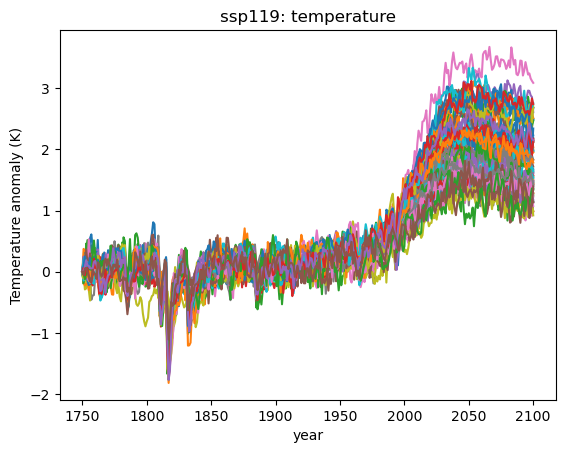

In [35]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp119', layer=0)], label=f.configs);
pl.title('ssp119: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'Temperature anomaly (K)')

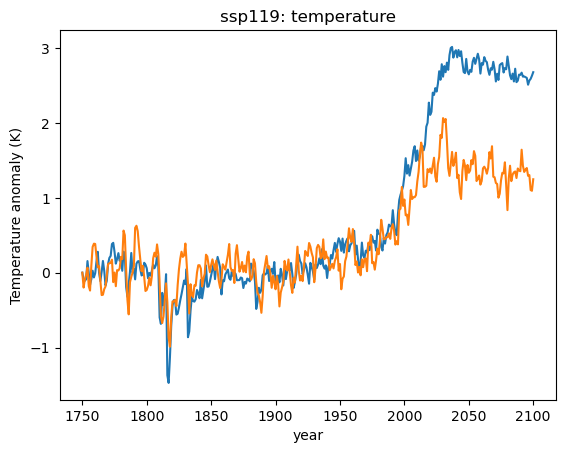

In [38]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp119', config='UKESM1-0-LL_r1i1p1f2', layer=0)], label=f.configs);
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp119', config='NorESM2-LM_r1i1p1f1', layer=0)], label=f.configs);
pl.title('ssp119: temperature')

pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'methane lifetime (yr)')

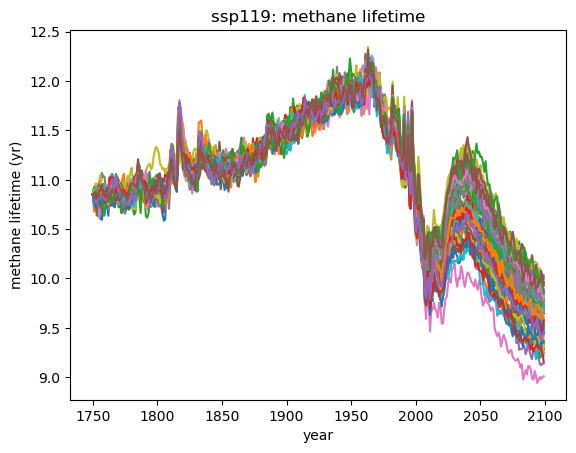

In [39]:
pl.plot(f.timebounds, f.species_configs['unperturbed_lifetime'].loc[dict(specie='CH4', gasbox=0)].data * f.alpha_lifetime.loc[dict(scenario='ssp119', specie='CH4')], label=f.configs);
pl.title('ssp119: methane lifetime')
pl.xlabel('year')
pl.ylabel('methane lifetime (yr)')

Text(0, 0.5, '[1]')

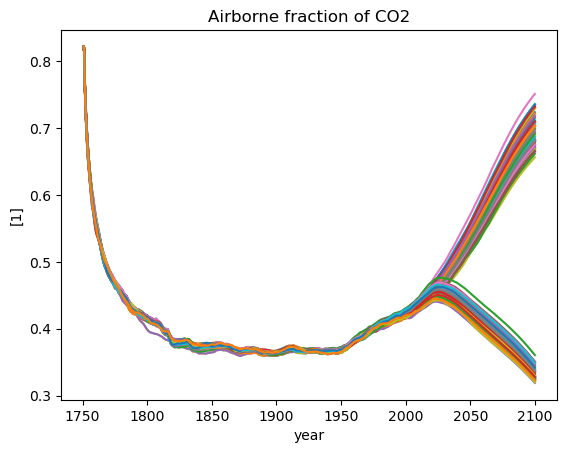

In [41]:
pl.plot(f.timebounds, f.airborne_fraction.loc[dict(scenario='ssp585', specie='CO2')], label=f.configs);
pl.plot(f.timebounds, f.airborne_fraction.loc[dict(scenario='ssp119', specie='CO2')], label=f.configs);

pl.title('Airborne fraction of CO2')
pl.xlabel('year')
pl.ylabel('[1]')

Text(0, 0.5, 'J')

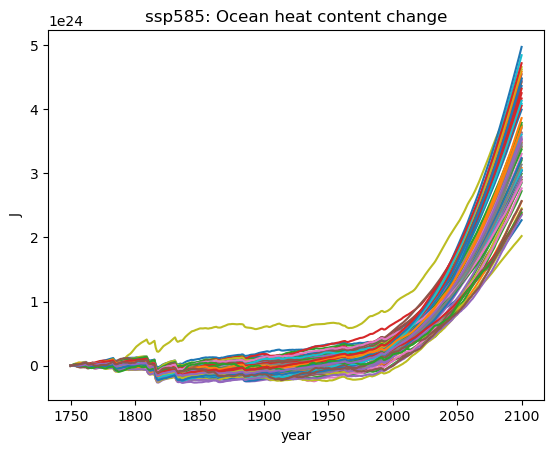

In [42]:
pl.plot(f.timebounds, f.ocean_heat_content_change.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Ocean heat content change')
pl.xlabel('year')
pl.ylabel('J')

In [43]:
dir(f)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_aci_indices',
 '_aerosol_chemistry_from_concentration_indices',
 '_aerosol_chemistry_from_emissions_indices',
 '_ari_indices',
 '_aviation_nox_indices',
 '_bc_indices',
 '_cfc11_indices',
 '_ch4_indices',
 '_ch4_method',
 '_check_properties',
 '_co2_afolu_indices',
 '_co2_ffi_indices',
 '_co2_indices',
 '_contrails_indices',
 '_eesc_indices',
 '_ghg_forward_indices',
 '_ghg_indices',
 '_ghg_inverse_indices',
 '_ghg_method',
 '_h2ostrat_indices',
 '_halogen_indices',
 '_landuse_indices',
 '_lapsi_indices',
 '_make_ebms',
 '_make_indices',
 '_minor_ghg_indices',
 '_n2o_indices',
 '_n_configs',
 '_n_gasbox

Text(0, 0.5, 'GtCO2')

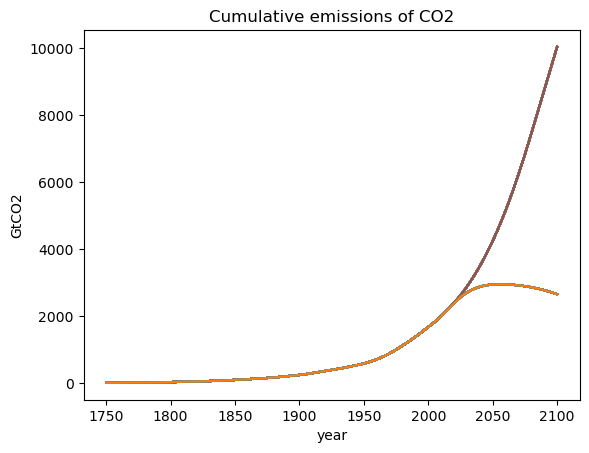

In [46]:
pl.plot(f.timebounds, f.cumulative_emissions.loc[dict(scenario='ssp585', specie='CO2')], label=f.configs);
pl.plot(f.timebounds, f.cumulative_emissions.loc[dict(scenario='ssp119', specie='CO2')], label=f.configs);

pl.title('Cumulative emissions of CO2')
pl.xlabel('year')
pl.ylabel('GtCO2')

In [47]:
f.emissions.loc[dict(scenario='ssp245', specie='CH4')]

<xarray.DataArray (timepoints: 350, config: 66)>
array([[ 19.01978312,  19.01978312,  19.01978312, ...,  19.01978312,
         19.01978312,  19.01978312],
       [ 18.91510887,  18.91510887,  18.91510887, ...,  18.91510887,
         18.91510887,  18.91510887],
       [ 18.88971181,  18.88971181,  18.88971181, ...,  18.88971181,
         18.88971181,  18.88971181],
       ...,
       [296.25195283, 296.25195283, 296.25195283, ..., 296.25195283,
        296.25195283, 296.25195283],
       [295.88561409, 295.88561409, 295.88561409, ..., 295.88561409,
        295.88561409, 295.88561409],
       [295.51927535, 295.51927535, 295.51927535, ..., 295.51927535,
        295.51927535, 295.51927535]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.752e+03 ... 2.098e+03 2.1e+03
    scenario    <U11 'ssp245'
  * config      (config) <U24 'CAMS-CSM1-0_r1i1p1f1' ... 'MIROC-ES2L_r1i1p1f2'
    specie      <U43 'CH4'

Defining time in emissions you need to remember to go from the midpoint of the year you are interested in, so go 2015.5 to get 2015.

In [52]:
f.emissions.loc[
    dict(
        scenario='ssp245', 
        specie='CH4', 
        timepoints=np.arange(2015.5, 2100.5)
    )
]

<xarray.DataArray (timepoints: 85, config: 66)>
array([[388.07279566, 388.07279566, 388.07279566, ..., 388.07279566,
        388.07279566, 388.07279566],
       [388.07635106, 388.07635106, 388.07635106, ..., 388.07635106,
        388.07635106, 388.07635106],
       [388.07990646, 388.07990646, 388.07990646, ..., 388.07990646,
        388.07990646, 388.07990646],
       ...,
       [296.25195283, 296.25195283, 296.25195283, ..., 296.25195283,
        296.25195283, 296.25195283],
       [295.88561409, 295.88561409, 295.88561409, ..., 295.88561409,
        295.88561409, 295.88561409],
       [295.51927535, 295.51927535, 295.51927535, ..., 295.51927535,
        295.51927535, 295.51927535]])
Coordinates:
  * timepoints  (timepoints) float64 2.016e+03 2.016e+03 ... 2.098e+03 2.1e+03
    scenario    <U11 'ssp245'
  * config      (config) <U24 'CAMS-CSM1-0_r1i1p1f1' ... 'MIROC-ES2L_r1i1p1f2'
    specie      <U43 'CH4'

In [53]:
f.emissions.loc[
    dict(
        scenario='ssp245', 
        specie='CH4', 
        timepoints=np.arange(2015.5, 2100.5)
    )
]=0.2*f.emissions.loc[
    dict(
        scenario='ssp245', 
        specie='CH4', 
        timepoints=np.arange(2015.5, 2100.5)
    )
]

In [54]:
f.emissions.loc[
    dict(
        scenario='ssp245', 
        specie='CH4', 
        timepoints=np.arange(2015.5, 2100.5)
    )
]

<xarray.DataArray (timepoints: 85, config: 66)>
array([[77.61455913, 77.61455913, 77.61455913, ..., 77.61455913,
        77.61455913, 77.61455913],
       [77.61527021, 77.61527021, 77.61527021, ..., 77.61527021,
        77.61527021, 77.61527021],
       [77.61598129, 77.61598129, 77.61598129, ..., 77.61598129,
        77.61598129, 77.61598129],
       ...,
       [59.25039057, 59.25039057, 59.25039057, ..., 59.25039057,
        59.25039057, 59.25039057],
       [59.17712282, 59.17712282, 59.17712282, ..., 59.17712282,
        59.17712282, 59.17712282],
       [59.10385507, 59.10385507, 59.10385507, ..., 59.10385507,
        59.10385507, 59.10385507]])
Coordinates:
  * timepoints  (timepoints) float64 2.016e+03 2.016e+03 ... 2.098e+03 2.1e+03
    scenario    <U11 'ssp245'
  * config      (config) <U24 'CAMS-CSM1-0_r1i1p1f1' ... 'MIROC-ES2L_r1i1p1f2'
    specie      <U43 'CH4'